This is a work in progress notebook... sorry for no comments.

It is based on https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics

In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 128
im_height = 128
border = 5
im_chan = 2 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth
path_train = '../input/train/'
path_test = '../input/test/'

# Data Exploration

In [3]:
df_depths = pd.read_csv('../input/depths.csv', index_col='id')
df_depths.head()

,z
id,
4ac19fb269,306
1825fadf99,157
f59821d067,305
5b435fad9d,503
e340e7bfca,783


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7cf5d444a8>]],
      dtype=object)

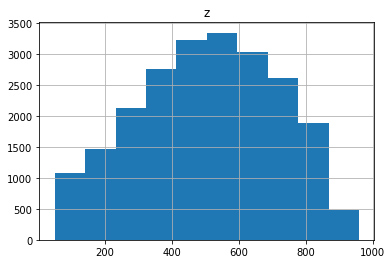

In [4]:
df_depths.hist()

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


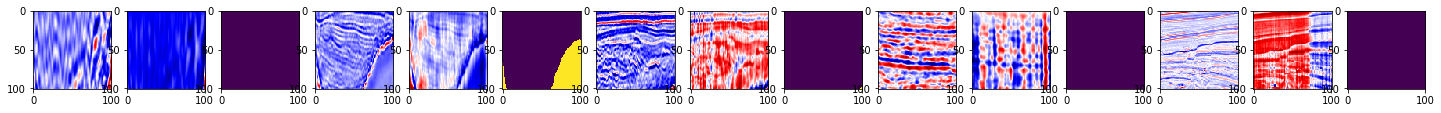

In [5]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(30,15))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('../input/train/images/' + img_name + '.png', grayscale=True)
    img_mask = load_img('../input/train/masks/' + img_name + '.png', grayscale=True)
    
    img = np.array(img)
    img_cumsum = (np.float32(img)-img.mean()).cumsum(axis=0)
    img_mask = np.array(img_mask)
    
    plt.subplot(1,3*(1+len(ids)),q*3-2)
    plt.imshow(img, cmap='seismic')
    plt.subplot(1,3*(1+len(ids)),q*3-1)
    plt.imshow(img_cumsum, cmap='seismic')
    plt.subplot(1,3*(1+len(ids)),q*3)
    plt.imshow(img_mask)
plt.show()

In [6]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [7]:
# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    
    # Depth
    X_feat[n] = df_depths.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


In [8]:
# Split train and valid
X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [9]:
# Normalize X_feat
x_feat_mean = X_feat_train.mean(axis=0, keepdims=True)
x_feat_std = X_feat_train.std(axis=0, keepdims=True)
X_feat_train -= x_feat_mean
X_feat_train /= x_feat_std

X_feat_valid -= x_feat_mean
X_feat_valid /= x_feat_std

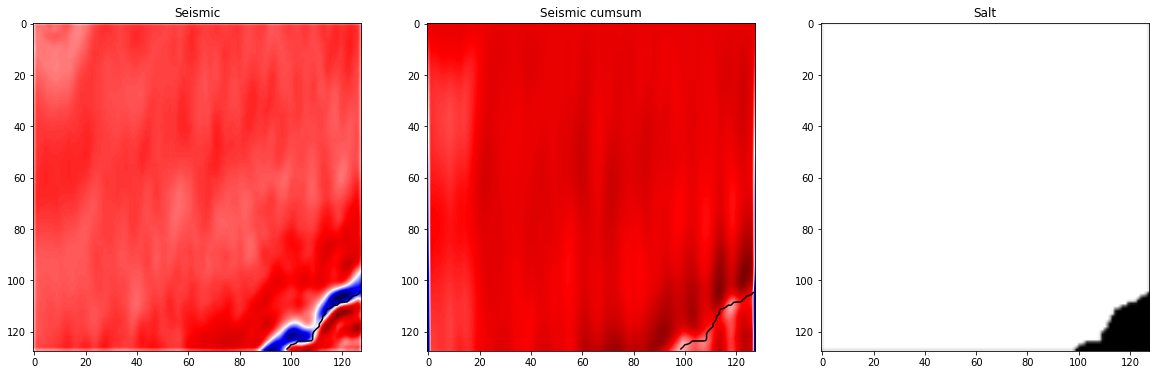

In [10]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))

has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(X_train[ix, ..., 1], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[1].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[1].set_title('Seismic cumsum')

ax[2].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[2].set_title('Salt');

# Train Model

In [11]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [12]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')
input_features = Input((n_features, ), name='feat')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# Join features information in the depthest layer
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_2[0][0]                   
_____________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=50, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 3400 samples, validate on 600 samples
Epoch 1/50
3400/3400 [==============================] - 10s 3ms/step - loss: 0.5453 - val_loss: 0.5130

Epoch 00001: val_loss improved from inf to 0.51297, saving model to model-tgs-salt-1.h5
Epoch 2/50
3400/3400 [==============================] - 4s 1ms/step - loss: 0.4658 - val_loss: 0.4369

Epoch 00002: val_loss improved from 0.51297 to 0.43692, saving model to model-tgs-salt-1.h5
Epoch 3/50
3400/3400 [==============================] - 4s 1ms/step - loss: 0.3823 - val_loss: 0.3680

Epoch 00003: val_loss improved from 0.43692 to 0.36797, saving model to model-tgs-salt-1.h5
Epoch 4/50
3400/3400 [==============================] - 4s 1ms/step - loss: 0.2995 - val_loss: 0.2854

Epoch 00004: val_loss improved from 0.36797 to 0.28544, saving model to model-tgs-salt-1.h5
Epoch 5/50
3400/3400 [==============================] - 4s 1ms/step - loss: 0.2688 - val_loss: 0.2493

Epoch 00005: val_loss imp

# Test Data
First we'll get the test data. This takes a while, it's 18000 samples.

In [ ]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.float32)
X_feat_test = np.zeros((len(test_ids), n_features), dtype=np.float32)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    
    # Depth
    X_feat_test[n] = df_depths.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True)
    x = img_to_array(img)
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x[border:-border, border:-border].mean()
    x_csum = (np.float32(x)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Save images
    X_test[n, ..., 0] = x.squeeze() / 255
    X_test[n, ..., 1] = x_csum.squeeze()

print('Done!')

In [ ]:
# Normalize X_test_feats
X_feat_test -= x_feat_mean
X_feat_test /= x_feat_std

In [ ]:
# Load best model
model.load_weights('model-tgs-salt-1.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate({'img': X_valid, 'feat': X_feat_valid}, y_valid, verbose=1)

In [ ]:
# Predict on train, val and test
preds_train = model.predict({'img': X_train, 'feat': X_feat_train}, verbose=1)
preds_val = model.predict({'img': X_valid, 'feat': X_feat_valid}, verbose=1)
preds_test = model.predict({'img': X_test, 'feat': X_feat_test}, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [ ]:
preds_test_upsampled[0].shape

We'll look at it again, just to be sure.

In [ ]:
def plot_sample(X, y, preds):
    ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(X[ix, ..., 1], cmap='seismic')
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('Seismic cumsum')

    ax[2].imshow(y[ix].squeeze())
    ax[2].set_title('Salt')

    ax[3].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Pred');

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train)

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val)

# Threshold optimization

In [ ]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
thres = np.linspace(0.25, 0.75, 20)
thres_ioc = [iou_metric_batch(y_valid, np.int32(preds_val > t)) for t in tqdm_notebook(thres)]

In [ ]:
plt.plot(thres, thres_ioc);

In [ ]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

# Prepare Submission
We need to prepare the submission. A nice CSV with predictions. All of this is one to one from Ketil and does not differ from any of the other segmentation tasks. Check them out to improve on this.

In [ ]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {id_[:-4]:RLenc(np.round(preds_test_upsampled[i] > best_thres)) for i,id_ in tqdm_notebook(enumerate(test_ids))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')